# About Dataset

This dataset has two columns

text: A string feature representing the content of the Twitter message.

label: A classification label indicating the primary emotion, with values ranging from 0 to 5.

In label column the emotions are classified into six categories: sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5).

In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import pandas as pd
from datasets import Dataset

In [ ]:
# load the data set
df = pd.read_csv("/content/text.csv")

In [ ]:
# print the first five rows
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


# Exploratory data Analysis (EDA)

In [ ]:
# print the length of datset
print(len(df))

416809


In [ ]:
# check the columns in our dataset
df.columns

Index(['Unnamed: 0', 'text', 'label'], dtype='object')

In [ ]:
# our column label has been encoded Six categories: sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5).
df['label'].unique()

array([4, 0, 2, 1, 5, 3])

In [ ]:
# drop irrevelant columns
df = df.drop(columns=['Unnamed: 0'])

In [ ]:
df.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [ ]:
df.isnull().sum() # check for null values in labels column

,0
text,0
label,0


# Plot bar graph to compare the labels in the data

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
label_counts = df['label'].value_counts().sort_index()
emotion_labels = ['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise']


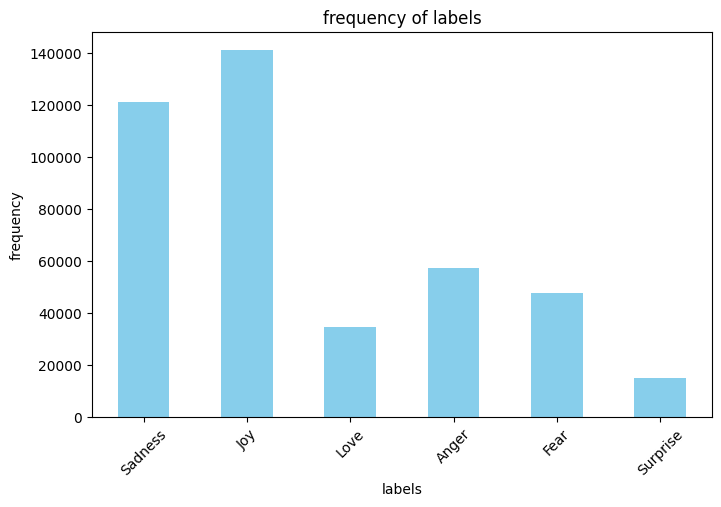

In [ ]:
plt.figure(figsize=(8,5))
label_counts.plot(kind = 'bar',color='skyblue')
plt.title('frequency of labels')
plt.xlabel('labels')
plt.ylabel('frequency')
plt.xticks(ticks=range(6), labels=emotion_labels, rotation=45)
plt.show()

# Data Preparation
Split the data into training and testing for model evaluation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt


In [ ]:
# Load  the first 30,000 rows of text.csv
# split the data set into training and testing
df = pd.read_csv("text.csv").head(15000)
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)


# Now train the dataset using distilbert, gpt-2 for emotional Classification

# 1. Using DistilBert model

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import torch
# Load tokenizer and model locally
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=6)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])


Map:   0%|          | 0/10500 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

In [ ]:
# Training setup define parameters for our sample
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    num_train_epochs=1,
    per_device_train_batch_size=8,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Metrics for evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = torch.tensor(pred.predictions).argmax(dim=1)  # Convert to tensor and apply argmax

    # Calculate accuracy
    acc = accuracy_score(labels, preds)

    # Calculate precision, recall, and F1-score (weighted)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")

    # Return metrics
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [ ]:
# Trainer for training the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)


In [ ]:
# Train and evaluate
trainer.train()
print("Evaluation results:", trainer.evaluate())


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.299000,0.220180,0.922444,0.925793,0.922444,0.922665


Evaluation results: {'eval_loss': 0.22017982602119446, 'eval_accuracy': 0.9224444444444444, 'eval_precision': 0.9257926390716331, 'eval_recall': 0.9224444444444444, 'eval_f1': 0.9226645884969811, 'eval_runtime': 16.6536, 'eval_samples_per_second': 270.211, 'eval_steps_per_second': 33.806, 'epoch': 1.0}


In [ ]:
# Make predictions on the test dataset
predictions = trainer.predict(test_dataset)

In [ ]:
# Convert predictions to labels
predicted_labels = torch.tensor(predictions.predictions).argmax(dim=1)
true_labels = predictions.label_ids


In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch

# Sample dataset
sample_texts = [
    "I feel so alone and hopeless.",
    "This is the happiest day of my life!",
    "I love spending time with my family.",
    "I can't believe they did this to me!",
    "I'm so scared about the future.",
    "Wow, I wasn't expecting this at all!",
    "Life just feels so overwhelming.",
    "What a delightful surprise!",
    "They mean the world to me.",
    "How dare they talk to me like that!",
]

true_labels = ["Sadness", "Joy", "Love", "Anger", "Fear", "Surprise", "Sadness", "Surprise", "Love", "Anger"]

# Define emotion labels
emotion_labels = ["Sadness", "Joy", "Love", "Anger", "Fear", "Surprise"]

# Tokenize the inputs
tokenized_inputs = tokenizer(
    sample_texts,
    padding=True,
    truncation=True,
    return_tensors="pt"
)

# Ensure the model and inputs are on the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
tokenized_inputs = {key: value.to(device) for key, value in tokenized_inputs.items()}

# Get predictions
model.eval()
with torch.no_grad():
    outputs = model(**tokenized_inputs)
    logits = outputs.logits  # Raw predictions
    predicted_labels = logits.argmax(dim=-1).tolist()  # Convert logits to label IDs

# Map label id's to emotion labels
predicted_emotions = [emotion_labels[label_id] for label_id in predicted_labels]

# Display the predictions
for i, text in enumerate(sample_texts):
    print(f"Text: {text}")
    print(f"True Label: {true_labels[i]}, Predicted Label: {predicted_emotions[i]}\n")


Text: I feel so alone and hopeless.
True Label: Sadness, Predicted Label: Sadness

Text: This is the happiest day of my life!
True Label: Joy, Predicted Label: Joy

Text: I love spending time with my family.
True Label: Love, Predicted Label: Joy

Text: I can't believe they did this to me!
True Label: Anger, Predicted Label: Anger

Text: I'm so scared about the future.
True Label: Fear, Predicted Label: Fear

Text: Wow, I wasn't expecting this at all!
True Label: Surprise, Predicted Label: Surprise

Text: Life just feels so overwhelming.
True Label: Sadness, Predicted Label: Fear

Text: What a delightful surprise!
True Label: Surprise, Predicted Label: Joy

Text: They mean the world to me.
True Label: Love, Predicted Label: Anger

Text: How dare they talk to me like that!
True Label: Anger, Predicted Label: Anger



In [ ]:
# print the confusion matrix for detailed visual metrics
from sklearn.metrics import confusion_matrix
predictions = trainer.predict(test_dataset)
predicted_labels = torch.tensor(predictions.predictions).argmax(dim=1)
true_labels = predictions.label_ids
# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

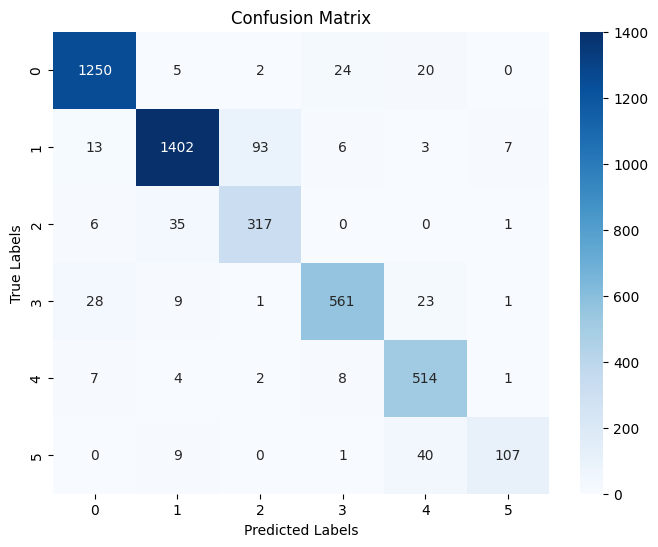

In [ ]:
import seaborn as sns
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(6), yticklabels=range(6))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


1. **True Positives (TP):**
  - **Sadness (0):** 1250
   - **Joy (1):** 1402
   - **Love (2):** 317
   - **Anger (3):** 561
   - **Fear (4):** 514
   - **Surprise (5):** 107

   These are the cases where the model correctly predicted the emotion.

2. **False Positives (FP):**
   - **Sadness (0):** 51
   - **Joy (1):** 122
   - **Love (2):** 42
   - **Anger (3):** 62
   - **Fear (4):** 22
   - **Surprise (5):** 50

   These represent the instances where the model incorrectly predicted the emotion.

3. **False Negatives (FN):**
   - **Sadness (0):** 54
   - **Joy (1):** 62
   - **Love (2):** 322
   - **Anger (3):** 594
   - **Fear (4):** 552
   - **Surprise (5):** 110

   These are the cases where the model missed the emotion, predicting something else instead.

4. **True Negatives (TN):**
   - **Sadness (0):** 4839  
   - **Joy (1):** 4608  
   - **Love (2):** 5513  
   - **Anger (3):** 4977  
   - **Fear (4):** 5106  
   - **Surprise (5):** 5897  

   These are the cases where the model correctly predicted that the sample did not belong to the given emotion.


# 2) Using GPT Model

In [ ]:
# using GPT-2
!pip install transformers torch


In [ ]:
from transformers import GPT2ForSequenceClassification, GPT2Tokenizer, Trainer, TrainingArguments
from datasets import load_dataset, DatasetDict
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import torch

# Load dataset and use a single split
text_dataset = load_dataset('csv', data_files='/content/text.csv')['train']

# Limit dataset to 30,000 rows and shuffle for more diverse performance
text_dataset = text_dataset.shuffle(seed=42).select(range(15000))

# Split into 70% train and 30% test
split = text_dataset.train_test_split(test_size=0.3, seed=42)
train_dataset = split['train']
test_dataset = split['test']



# Tokenizer using GPT2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Add padding token to the tokenizer (eos_token used as padding token) to ensure the end of text sentence
tokenizer.pad_token = tokenizer.eos_token

# Make sure the padding token is also known to the model
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=6)  # there are 6 classes or labels for our target column
model.config.pad_token_id = tokenizer.pad_token_id

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

# Apply tokenization
tokenized_datasets = train_dataset.map(tokenize_function, batched=True)

# Use the entire dataset for training and testing
val_dataset = tokenized_datasets

# Define compute metrics function
def compute_metrics(p):
    predictions, labels = p
    preds = predictions.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Training arguments with smaller batch size and mixed precision for reducing load on our resources
training_args = TrainingArguments(
    output_dir='./results',          # Output directory dertermines where to store the results
    num_train_epochs=1,              # Number of epochs for our training
    per_device_train_batch_size=2,   # Batch size of 2
    per_device_eval_batch_size=2,    # Same batch size for evaluation
    evaluation_strategy="epoch",     # Evaluate at the end of each epoch
    save_strategy="epoch",           # Save the model every epoch
    logging_dir='./logs',            # Directory for logs
    logging_steps=10,                # Log every 10 steps to ensure if there is error occured in the log
    load_best_model_at_end=True,     # Load the best model at the end
    fp16=True,                       # Enable mixed precision
)

# Define the Trainer
trainer = Trainer(
    model=model,                        # Model used
    args=training_args,                 # Training arguments
    train_dataset=tokenized_datasets,   # Training dataset
    eval_dataset=val_dataset,           # Validation dataset
    compute_metrics=compute_metrics,    #  metrics function
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()

# Print evaluation results
print("Evaluation results:", results)


Generating train split: 0 examples [00:00, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/10500 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.010000,0.275275,0.943048,0.946279,0.943048,0.942677


Evaluation results: {'eval_loss': 0.2752746045589447, 'eval_accuracy': 0.943047619047619, 'eval_precision': 0.9462793034380603, 'eval_recall': 0.943047619047619, 'eval_f1': 0.9426770484097885, 'eval_runtime': 323.1999, 'eval_samples_per_second': 32.488, 'eval_steps_per_second': 16.244, 'epoch': 1.0}


In [ ]:
# Emotion categories corresponding to the label integers
emotion_labels = {0: 'Sadness', 1: 'Joy', 2: 'Love', 3: 'Anger', 4: 'Fear', 5: 'Surprise'}

# Sample texts with actual labels
sample_texts = [
    "I can't stop crying, everything feels so heavy.",  # Actual label: Sadness (0)
    "This is the happiest I've felt in years!",        # Actual label: Joy (1)
    "I love spending evenings with my partner.",       # Actual label: Love (2)
    "I am so mad right now, I can't even think straight.",  # Actual label: Anger (3)
    "I'm terrified of what's going to happen next.",  # Actual label: Fear (4)
    "This unexpected gift completely surprised me!",  # Actual label: Surprise (5)
    "The grief is overwhelming and I feel lost.",      # Actual label: Sadness (0)
    "Joy fills my heart when I see the sunrise.",      # Actual label: Joy (1)
    "Holding their hand makes me feel at peace.",      # Actual label: Love (2)
    "Why would they do something so inconsiderate? I'm furious!"  # Actual label: Anger (3)
]

actual_labels = [0, 1, 2, 3, 4, 5, 0, 1, 2, 3]

# Tokenization function
def tokenize_function(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

# Put model in evaluation mode
model.eval()

# Process each sample text
for i, text in enumerate(sample_texts):
    # Tokenize the text
    inputs = tokenize_function([text])

    # Move the tensors to the same device as the model if using GPU (optional)
    inputs = {key: value.to(model.device) for key, value in inputs.items()}

    # Make predictions with the model
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_label = torch.argmax(logits, dim=-1).item()  # Get the predicted label

    # Map the predicted label to the emotion
    predicted_emotion = emotion_labels[predicted_label]
    actual_emotion = emotion_labels[actual_labels[i]]

    # Print the text, predicted emotion, and actual emotion
    print(f"Sample {i+1}:")
    print(f"  Text: {text}")
    print(f"  Predicted: {predicted_emotion} ({predicted_label})")
    print(f"  Actual: {actual_emotion} ({actual_labels[i]})")
    print("-" * 20)


Sample 1:
  Text: I can't stop crying, everything feels so heavy.
  Predicted: Sadness (0)
  Actual: Sadness (0)
--------------------
Sample 2:
  Text: This is the happiest I've felt in years!
  Predicted: Joy (1)
  Actual: Joy (1)
--------------------
Sample 3:
  Text: I love spending evenings with my partner.
  Predicted: Anger (3)
  Actual: Love (2)
--------------------
Sample 4:
  Text: I am so mad right now, I can't even think straight.
  Predicted: Anger (3)
  Actual: Anger (3)
--------------------
Sample 5:
  Text: I'm terrified of what's going to happen next.
  Predicted: Fear (4)
  Actual: Fear (4)
--------------------
Sample 6:
  Text: This unexpected gift completely surprised me!
  Predicted: Surprise (5)
  Actual: Surprise (5)
--------------------
Sample 7:
  Text: The grief is overwhelming and I feel lost.
  Predicted: Sadness (0)
  Actual: Sadness (0)
--------------------
Sample 8:
  Text: Joy fills my heart when I see the sunrise.
  Predicted: Joy (1)
  Actual: Joy (1)
-

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

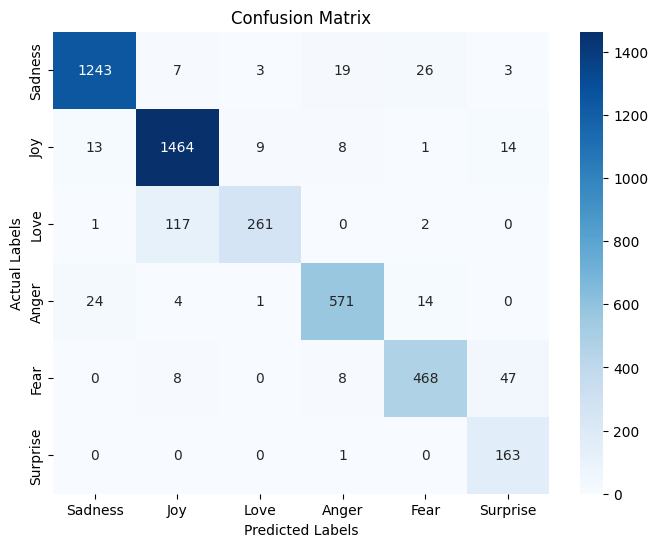

In [ ]:

# Tokenize the test dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

# Apply tokenization to the test dataset
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

# Convert the tokenized test dataset to PyTorch tensors
tokenized_test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Make predictions on the tokenized test dataset
predictions = trainer.predict(tokenized_test_dataset)

# Extract predicted labels by taking the argmax of logits
predicted_labels = np.argmax(predictions.predictions, axis=-1)

# Get the actual labels from the test dataset
actual_labels = tokenized_test_dataset['label']

# Calculate confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[emotion_labels[label] for label in np.unique(actual_labels)],
            yticklabels=[emotion_labels[label] for label in np.unique(actual_labels)])
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()


 the values for **True Positives (TP)**, **False Positives (FP)**, **False Negatives (FN)**, and **True Negatives (TN)** based on the confusion matrix:

**True Positives (TP):**
  - **Sadness (0):** 1243
  - **Joy (1):** 1464
  - **Love (2):** 261
  - **Anger (3):** 571
  - **Fear (4):** 468
  - **Surprise (5):** 163

**False Positives (FP):**
  - **Sadness (0):** 13
  - **Joy (1):** 9
  - **Love (2):** 0
  - **Anger (3):** 14
  - **Fear (4):** 8
  - **Surprise (5):** 1

**False Negatives (FN):**
  - **Sadness (0):** 24
  - **Joy (1):** 8
  - **Love (2):** 2
  - **Anger (3):** 0
  - **Fear (4):** 8
  - **Surprise (5):** 0

**True Negatives (TN):**
  - **Sadness (0):** 2877
  - **Joy (1):** 2676
  - **Love (2):** 3894
  - **Anger (3):** 3572
  - **Fear (4):** 3673
  - **Surprise (5):** 3993
